# Multi-Layer Perceptron

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
#https://www.pluralsight.com/guides/building-your-first-pytorch-solution

## Data normalization

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Loading data

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ..\input\MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ..\input\MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ..\input\MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ..\input\MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ..\input\MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ..\input\MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ..\input\MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ..\input\MNIST/MNIST/raw

torch.Size([64, 1, 28, 28])
torch.Size([64])


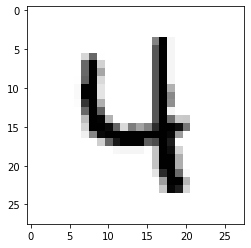

In [3]:
def load_test_train_data_MNIST():
    trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    testset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_test_train_data_MNIST()
dataiter = iter(trainloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

## Create Multi-layer perceptron network model

In [5]:
def create_MLP_model():
    # Model creation with neural net Sequential model
    model=nn.Sequential(nn.Linear(784,128), # 1 layer:- 784 input 128 o/p
                        #nn.ReLU(),          # Defining Regular linear unit as activation
                        nn.Sigmoid(),
                        nn.Linear(128,64),  # 2 Layer:- 128 Input and 64 O/p
                        #nn.Tanh(),          # Defining Regular linear unit as activation
                        nn.Sigmoid(),
                        nn.Linear(64,10),   # 3 Layer:- 64 Input and 10 O/P as (0-9)
                        nn.LogSoftmax(dim=1) # Defining the log softmax to find the probablities for the last output unit
                      ) 
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device: ", device)
mlp_model = create_MLP_model()

#moving models to device
mlp_model.to(device)
#create error criterion
criterion = nn.NLLLoss() 
print("MLP model")
print(mlp_model)


Running on device:  cuda
MLP model
Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


## Train model

In [7]:
def train_model(model, criterion, epochs = 15, lr = 0.01):

    time0 = time()    
    running_loss_list= []
    epochs_list = []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        
        #go for every batch
        for images, labels in trainloader:
            #move data to specific device
            images = images.to(device)
            labels = labels.to(device)
            # Flatenning MNIST images with size [64,784] (for MLP)
            
            images = images.view(images.shape[0], -1) 
            
            # defining gradient in each epoch as 0
            optimizer.zero_grad()            
            # modeling for each image batch
            output = model(images)

            # calculating the loss
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            # calculating the loss
            running_loss += loss.item()

        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model

print("Training MLP model")
mlp_model = train_model(mlp_model, criterion, epochs = 15, lr = 0.01)


Training MLP model
Epoch 0 - Training loss: 1.543797011695691
Epoch 1 - Training loss: 0.4879878269139129
Epoch 2 - Training loss: 0.33864478754209304
Epoch 3 - Training loss: 0.277817017337216
Epoch 4 - Training loss: 0.2367640914383537
Epoch 5 - Training loss: 0.2057777889994289
Epoch 6 - Training loss: 0.17971279294982648
Epoch 7 - Training loss: 0.15922791673255754
Epoch 8 - Training loss: 0.14392519144039514
Epoch 9 - Training loss: 0.1311875787823757
Epoch 10 - Training loss: 0.12002771326215632
Epoch 11 - Training loss: 0.11022217922619601
Epoch 12 - Training loss: 0.10205151775140943
Epoch 13 - Training loss: 0.09494360092518998
Epoch 14 - Training loss: 0.08941069696702238

Training Time (in minutes) = 2.7969231685002645


## Test model

In [8]:
def test_model_mlp(testloader, model):
    correct_count, all_count = 0, 0
    for images,labels in testloader:
      #move data to specific device
      images = images.to(device)
      labels = labels.to(device)
      for i in range(len(labels)):
        img = images[i].view(1, 784)
        #evaluate model with no grad
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        #get predicted label
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))





print("Testing MLP model")
test_model_mlp(testloader, mlp_model)

Testing MLP model
Number Of Images Tested = 10000

Model Accuracy = 0.9678
